# Prever quem sobreviveu ao naufrágio do Titanic  
  
Desafio do site **Kaggle** para prever, dadas as características, quem sobreviveu ao acidente do Titanic.

## Imports iniciais necessários  
  
* **numpy** para a álgebra linear
* **pandas** para o processamento e I/O dos dados

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Leitura dos dados

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

Informações do conjunto de dados:

In [3]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Pelas informações acima vemos que temos apenas 204 dados sobre ```Cabin```, 714 sobre ```Age``` e 889 sobre ```Embarked```.  
  
Como há poucos dados sobre ```Cabin```, não tem como supor valores sobre ela, então, vale a pena retirá-lo do conjunto de dados. Poucos dados faltam nas outras colunas, usaremos estratégias diferentes nelas.

In [4]:
train.drop('Cabin', axis=1, inplace=True)

Vendo as propriedades de ```Embarked```:

In [5]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Há abundância do valor ```S```, então, onde existe o valor nulo, é provável que seja ```S```, então, vamos preenchê-los com o mesmo.

In [6]:
train.Embarked.fillna('S', inplace=True)

## Visualização dos dados

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Informações sobre a sobrevivência dos tripulantes:

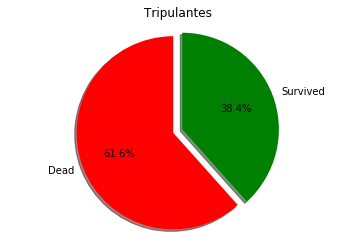

In [8]:
labels = ['Dead', 'Survived']
val_counts = train['Survived'].value_counts()

sizes = [val_counts[0], val_counts[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, shadow=True, startangle=90,
       explode=(0.1,0), autopct='%1.1f%%', colors=['red', 'green'])
ax.axis('equal')
plt.title('Tripulantes')
plt.show()

Transformando a *feature* ```Sex``` em *Boolean*:

In [9]:
def encode_sex(sex_col):
    return sex_col.map({'female': 0, 'male': 1}).astype('int')

In [10]:
train['Sex'] = encode_sex(train['Sex'])

Entendendo como a *feature* ```Sex``` se comporta no conjunto de dados:

In [11]:
def feature_analysis(data, feature, target, labels=None, autopct = True):
    ct = pd.crosstab(data[feature], data[target], margins=True)
    print("Análise do atributo {}".format(feature))
    cats = list(ct.index.values)
    cats.remove('All') # Remove the 'All' row which contains the total (the Margin that we added in crosstab)
    cats.sort()
#     print(cats)
    
    sizes = list(ct.loc[cats, 'All'])
    
#     print(sizes)
    if(labels==None):
        labels=cats
#     print(labels)
    fig, ax = plt.subplots()

    ax.pie(sizes, labels=labels, shadow=True, startangle=90, autopct= '%1.1f%%'  if autopct else None)
    ax.axis('equal')

    plt.title('Contagem de Passageiros por ' + feature)
    plt.show()
    
    print('Análise das mortes {}:'.format(feature))
    survivants_values = list(ct.loc[cats, 1])
    deads_values = list(ct.loc[cats, 0])

    ind = np.arange(len(cats))
    width = 0.2
    plt.bar(ind, survivants_values, width, label='Survived', color='green')
    plt.bar(ind+width, deads_values, width, label='Dead', color='red')

    plt.xticks(ind+width/2, labels)
    plt.yticks(np.arange(0, 500, 50))
    plt.legend(loc='upper right')
    plt.show()

Análise do atributo Sex


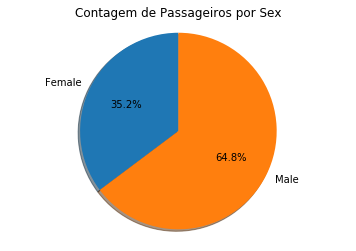

Análise das mortes Sex:


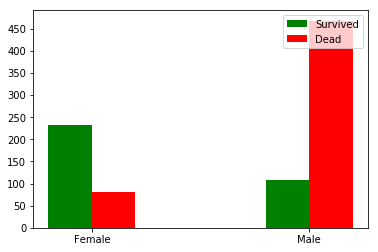

In [12]:
labels = ['Female', 'Male']
feature_analysis(train, 'Sex', 'Survived', labels)

Antes de trabalhar com a idade, vamos preencher os valores *NaN* com a média.

In [13]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


Antes de trabalhar com a idade, vamos preencher os valores NaN com a média.

In [14]:
train['Age'].fillna((train['Age'].mean()), inplace=True)

Para ter uma visão melhor, é boas práticas separar as idades por categoria:  
* *1-10 anos* $\rightarrow$ 0
* *11-17 anos* $\rightarrow$ 1
* *18-35 anos* $\rightarrow$ 2
* *36-50 anos* $\rightarrow$ 3
* *51 anos em diante* $\rightarrow$ 4

In [15]:
def construct_age_cat_col(age_col):
    #create a vector with size of len(age_col) and all values as -1
    age_cat_col = pd.Series([-1] * len(age_col))
    for i, val in age_col.iteritems():
        if val < 11:                 # Kids
            age_cat_col[i] = 0
        elif val >= 11 and val < 18: # Teens
            age_cat_col[i] = 1
        elif val >= 18 and val < 36: # Adults
            age_cat_col[i] = 2
        elif val >= 36 and val < 51: # Big Adults
            age_cat_col[i] = 3
        elif val >= 51:              # Seniors
            age_cat_col[i] = 4
        else:
            raise ValueError('Preprocessing Age: Age Value unsupported ! ', val)
    return age_cat_col

In [16]:
train['AgeCategory'] = construct_age_cat_col(train['Age'])
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,2


Proporção das categorias:

Análise do atributo AgeCategory


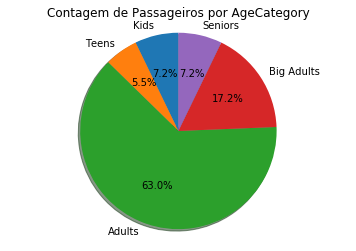

Análise das mortes AgeCategory:


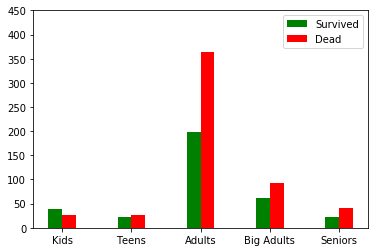

In [17]:
labels = ['Kids', 'Teens', 'Adults', 'Big Adults', 'Seniors']
feature_analysis(train, 'AgeCategory', 'Survived', labels)

Informações sobre a classe

Análise do atributo Pclass


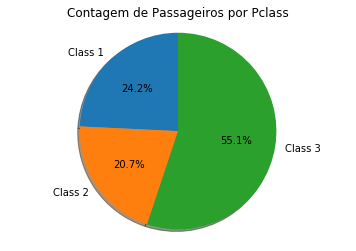

Análise das mortes Pclass:


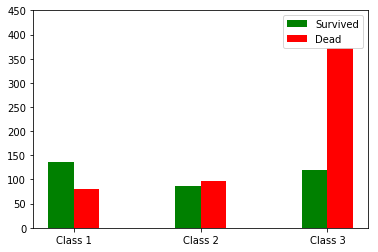

In [18]:
labels = ['Class 1', 'Class 2', 'Class 3']
feature_analysis(train, 'Pclass', 'Survived', labels)

Análise do atributo Embarked


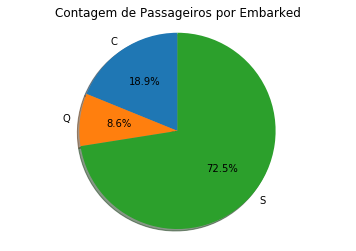

Análise das mortes Embarked:


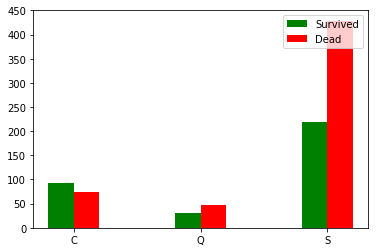

In [19]:
feature_analysis(train, 'Embarked', 'Survived')

Análise do atributo SibSp


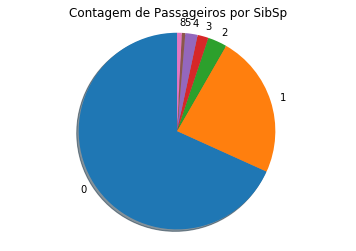

Análise das mortes SibSp:


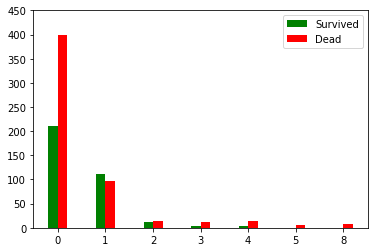

In [20]:
feature_analysis(train, 'SibSp', 'Survived', autopct=False)

Análise do atributo Parch


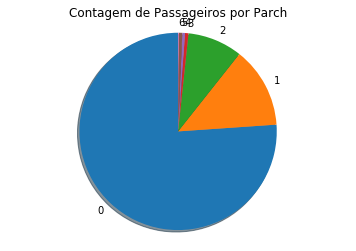

Análise das mortes Parch:


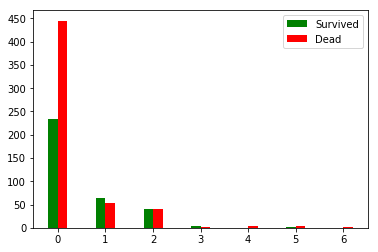

In [21]:
feature_analysis(train, 'Parch', 'Survived', autopct=False)

In [22]:
def construct_alone_col(parch_col, sibsp_col):
    alone_col = pd.Series([0] * len(parch_col))
    for i, val in alone_col.iteritems():
        if(parch_col[i] == 0 and sibsp_col[i] == 0):
            alone_col[i] = 1
    return alone_col

In [23]:
train['Alone'] = construct_alone_col(train['Parch'], train['SibSp'])

In [24]:
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [25]:
pd.crosstab(train['Title'], train['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [26]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                        'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                        'Jonkheer', 'Dona', 'Mlle'
                                        'Ms', 'Mme','Mlle', 'Ms'], 'Rare')

## Teste de performance com a engenharia das features no estado atual

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory,Alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,3,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,2,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,2,1,Mr


In [28]:
def encode_embarked(embarked_col):
    return embarked_col.map({'S': 0, 'Q': 1, 'C': 2}).astype('int')

In [29]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.697802
2,Mr,0.156673
3,Mrs,0.792000
4,Rare,0.444444


In [30]:
def encode_title(title_col):
    return title_col.map({"Master": 1, "Miss": 2, "Mr": 3, "Mrs": 4, "Rare": 5}).astype('int')

In [31]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AgeCategory,Alone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,2.116723,0.602694
std,257.353842,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.888036,0.489615
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,2.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,2.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,1.000000


In [ ]:
train.drop('Name', axis = 1, inplace=True)
train.drop('Ticket', axis = 1, inplace=True)
train.drop('PassengerId', axis = 1, inplace=True)
train['Embarked'] = encode_embarked(train['Embarked'])
train['Title'] = encode_title(train['Title'])

test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                        'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                        'Jonkheer', 'Dona', 'Mlle'
                                        'Ms', 'Mme','Mlle', 'Ms'], 'Rare')
test['Title'] = encode_title(test['Title'])
test.drop('Name', axis = 1, inplace=True)
test.drop('Ticket', axis = 1, inplace=True)
passenger_test_id = test['PassengerId']
test.drop('PassengerId', axis = 1, inplace=True)
test.drop('Cabin', axis = 1, inplace=True)

test['Fare'].fillna((train['Fare'].mean()), inplace=True)
test['Age'].fillna((train['Age'].mean()), inplace=True)
test['Sex'] = encode_sex(test['Sex'])
test['Embarked'] = encode_embarked(test['Embarked'])
test['AgeCategory'] = construct_age_cat_col(test['Age'])
test['Alone'] = construct_alone_col(test['Parch'], test['SibSp'])
test.head()

In [ ]:
# Produza uma matriz de dispersão para cada um dos pares de atributos dos dados
pd.plotting.scatter_matrix(train, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
plt.show()

In [ ]:
sns.heatmap(train.corr(), annot=True)
plt.show()

In [ ]:
y_train = train['Survived']
train.drop('Survived', axis = 1, inplace=True)
train.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# TODO: Inicializar o classificador
clf = RandomForestClassifier(n_estimators=10, n_jobs=8, random_state=0)

parameters = {"n_estimators": range(10, 150, 10), "min_samples_split":range(2, 20, 2), 
             "max_depth": range(2, 16, 2)}
 
grid_obj = GridSearchCV(clf, param_grid=parameters, cv=5)

grid_fit = grid_obj.fit(train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(train, y_train)).predict(train)
best_predictions = best_clf.predict(train)

In [ ]:
# Reportar os scores de antes e de depois
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_train, predictions)))
print(classification_report(predictions, y_train))

print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print(classification_report(best_predictions, y_train))

In [ ]:
predictions = (clf.fit(train, y_train)).predict(test)
best_predictions = best_clf.predict(test)

In [ ]:
data = {'Survived': best_predictions, 'PassengerId': passenger_test_id}

df = pd.DataFrame(data=data)

df.head()

In [ ]:
df.to_csv('prediction.csv',index=False)